### Time Series Forecasting with XGBoost

This notebook implements a time series forecasting pipeline using the **XGBoost Regressor** for three key agricultural and commodity-related time series:

- **Beef (Carne Vacuna)**
- **Wheat (Trigo)**
- **Soybean (Soja)**

The approach combines domain-specific feature engineering with time-aware model training and evaluation.

#### Feature Engineering

A set of time-based features was manually constructed to capture both trend and seasonal patterns, including:

- **Lag features**: Recent lags (e.g., 1-month, 12-month), first differences, and seasonal differences.
- **Seasonal differencing**: Calculated as the difference between current and 12-month lag values, capturing annual seasonality.
- **Month dummies**: One-hot encoding of the month variable to model seasonality directly.

These features were created for each of the three time series independently using a shared feature-generation function.

#### Train/Test Splitting and Validation

Each time series was split temporally, using **80% of the data for training** and **20% for testing**. To ensure proper time-aware validation, the model used **TimeSeriesSplit** cross-validation with 5 folds.

#### Hyperparameter Optimization

For each series, an **XGBoost Regressor** was trained and tuned using `GridSearchCV`. The grid included:

- `max_depth`, `min_child_weight`, `gamma`, `subsample`, `colsample_bytree`
- Fixed regularization parameters (`reg_alpha`, `reg_lambda`)
- A fixed learning rate

The best combination of hyperparameters was selected based on **negative mean squared error** (RMSE).

#### Model Evaluation

Each model was evaluated on the test set using the following metrics:

- **RMSE** (Root Mean Squared Error)
- **MAE** (Mean Absolute Error)
- **MAPE** (Mean Absolute Percentage Error)

Both training and test set predictions were generated for all three series, and visual comparisons were plotted to assess performance.

The models demonstrated strong ability to capture trends and seasonality, particularly when appropriate lag and seasonal features were included.

>  **Note**: Since the models rely on lag-based and calendar features, future forecasts depend on either known or estimated future values of these features. Recursive forecasting may be required for multi-step predictions.



In [85]:
import pandas as pd
import sys
sys.path.insert(0, '../src/')
import importlib
import read_data
importlib.reload(read_data)
from read_data import load_dataset, load_commodity

import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [86]:
df = load_dataset()

In [ ]:
def create_features(df, target_col, lags=[1], add_month_dummies=True):
    df_feat = pd.DataFrame(index=df.index)
    df_feat[target_col] = df[target_col]
    
    # Lags
    for lag in lags:
        df_feat[f'lag_{lag}'] = df[target_col].shift(lag)
    
    df_feat['lag_12']=df[target_col].shift(12)
    df_feat['diff_seas'] = df[target_col] - df[target_col].shift(12)
    df_feat['diff_price'] = df[target_col] - df[target_col].shift(1)
    
    # Estacionalidad (dummies de mes)
    if add_month_dummies:
        df_feat['month'] = df.index.month
        df_feat = pd.get_dummies(df_feat, columns=['month'], drop_first=True)
        df_feat.astype(float)
    return df_feat.dropna()

In [ ]:

df_feat = create_features(df, 'Carne Vacuna')

X = df_feat.drop(columns='Carne Vacuna')
y = df_feat['Carne Vacuna']

# Train/Test split temporal
train_size = int(len(df_feat) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Cross-validation + GridSearch
tscv = TimeSeriesSplit(n_splits=5)

params= {
    'max_depth': [3, 5],
    'min_child_weight': [1, 5],
    'gamma': [0, 0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8],
    'learning_rate': [0.1],
    'reg_alpha':[0.5], 'reg_lambda':[1.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(xgb, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


# Entrenamiento final + predicción


best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE_Test: {rmse_test:.2f}")
print(f"MAE_Test: {mae_test:.2f}")
print(f"MAPE_Test: {mape_test:.2f}%")

print(f"RMSE_Train: {rmse_train:.2f}")
print(f"MAE_Train: {mae_train:.2f}")
print(f"MAPE_Train: {mape_train:.2f}%")

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 5, 'reg_alpha': 0.5, 'reg_lambda': 1.0, 'subsample': 0.6}
RMSE_Test: 0.34
MAE_Test: 0.23
MAPE_Test: 3.86%
RMSE_Train: 0.07
MAE_Train: 0.05
MAPE_Train: 0.96%


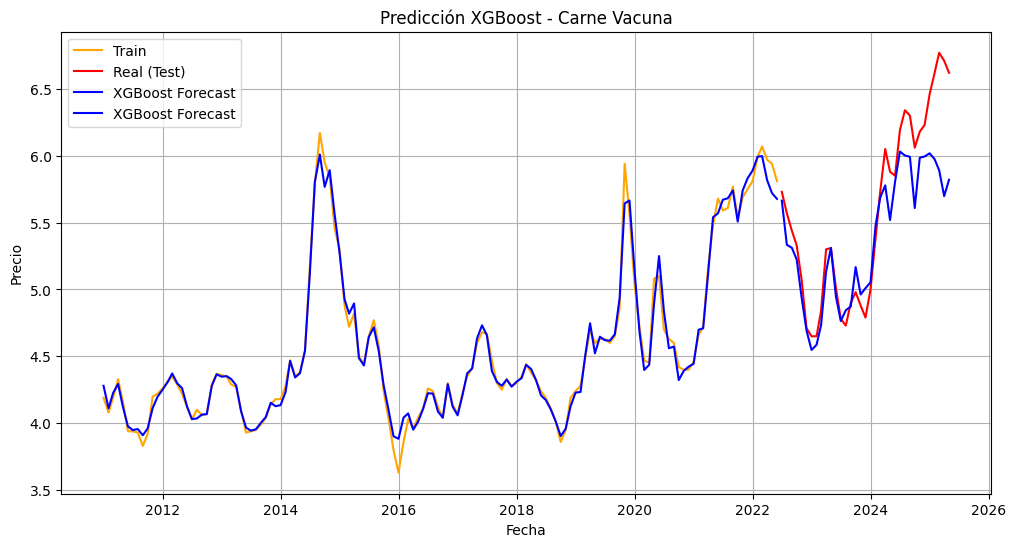

In [219]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train', color='orange')
plt.plot(y_test.index, y_test, label='Real (Test)', color='red')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', color='blue')
plt.plot(y_train.index, y_pred_train, label='XGBoost Forecast', color='blue')
plt.title("Predicción XGBoost - Carne Vacuna")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()

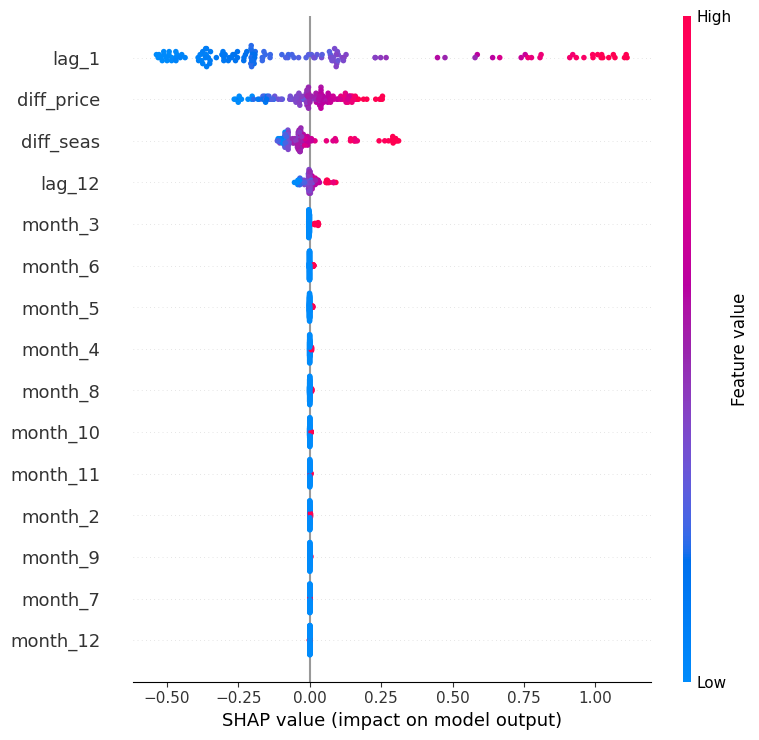

In [220]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

### Forecasting Soja

In [212]:
df_feat = create_features(df, 'Soja')

X = df_feat.drop(columns='Soja')
y = df_feat['Soja']

# Train/Test split temporal
train_size = int(len(df_feat) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Cross-validation + GridSearch
tscv = TimeSeriesSplit(n_splits=3)

params= {
    'max_depth': [3],
    'min_child_weight': [5, 10],
    'gamma': [0, 0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8],
    'learning_rate': [0.1],
    'reg_alpha':[1.0, 2.0, 5.0], 'reg_lambda':[1.0, 3.0, 5.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(xgb, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


# Entrenamiento final + predicción


best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE_Test: {rmse_test:.2f}")
print(f"MAE_Test: {mae_test:.2f}")
print(f"MAPE_Test: {mape_test:.2f}%")

print(f"RMSE_Train: {rmse_train:.2f}")
print(f"MAE_Train: {mae_train:.2f}")
print(f"MAPE_Train: {mape_train:.2f}%")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 2.0, 'reg_lambda': 1.0, 'subsample': 0.6}
RMSE_Test: 15.78
MAE_Test: 10.99
MAPE_Test: 2.09%
RMSE_Train: 4.61
MAE_Train: 3.40
MAPE_Train: 0.72%


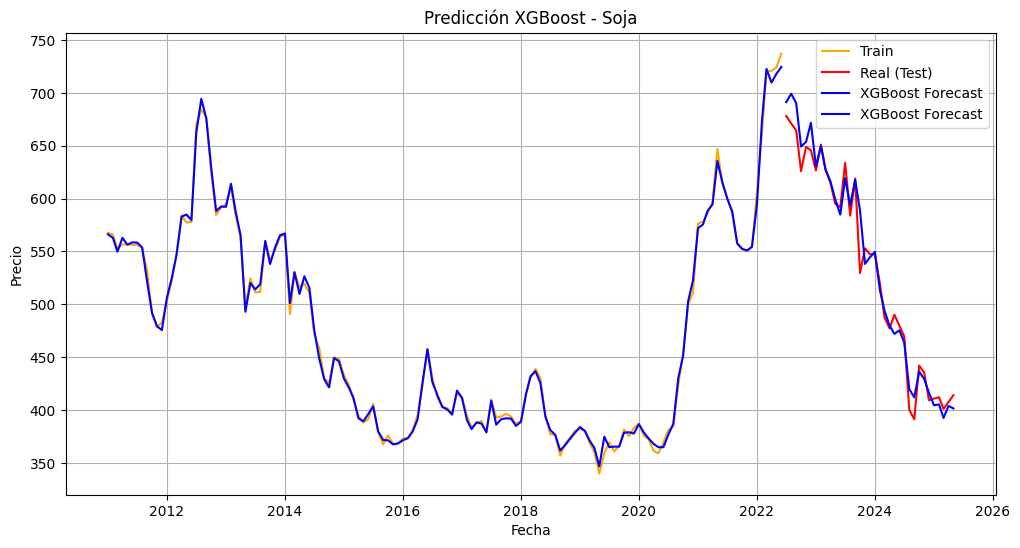

In [214]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train', color='orange')
plt.plot(y_test.index, y_test, label='Real (Test)', color='red')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', color='blue')
plt.plot(y_train.index, y_pred_train, label='XGBoost Forecast', color='blue')
plt.title("Predicción XGBoost - Soja")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)

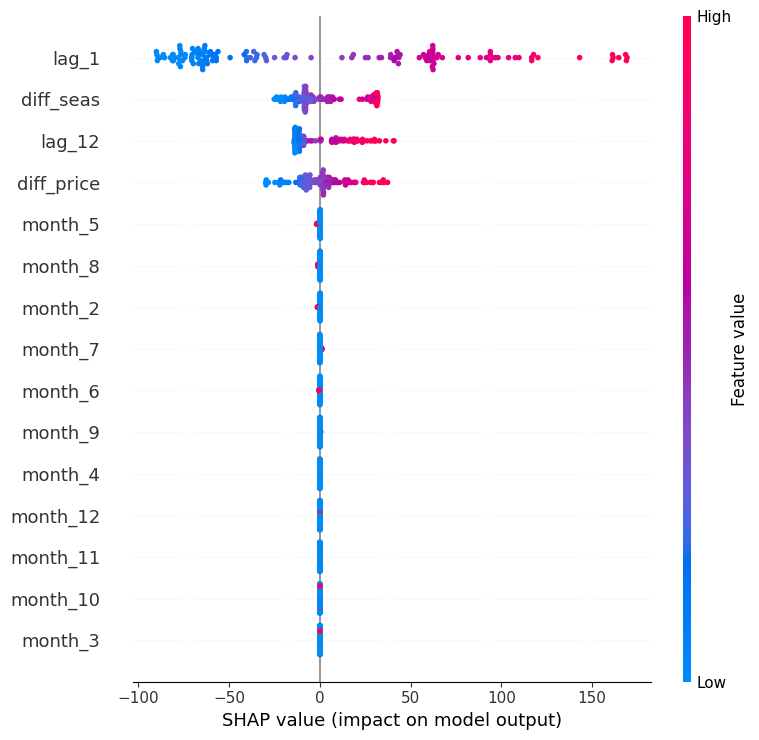

### Forecasting Trigo

In [221]:
df_feat = create_features(df, 'Trigo')

X = df_feat.drop(columns='Trigo')
y = df_feat['Trigo']

# Train/Test split temporal
train_size = int(len(df_feat) * 0.8)
X_train, X_test = X.iloc[:train_size], X.iloc[train_size:]
y_train, y_test = y.iloc[:train_size], y.iloc[train_size:]


# Cross-validation + GridSearch
tscv = TimeSeriesSplit(n_splits=3)

params= {
    'max_depth': [3],
    'min_child_weight': [5, 10],
    'gamma': [0, 0.5, 1],
    'subsample': [0.6, 0.8],
    'colsample_bytree': [0.8],
    'learning_rate': [0.1],
    'reg_alpha':[1.0, 2.0, 5.0], 'reg_lambda':[1.0, 3.0, 5.0]
}

xgb = XGBRegressor(objective='reg:squarederror', random_state=42)
grid = GridSearchCV(xgb, param_grid=params, cv=tscv, scoring='neg_mean_squared_error', verbose=1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)


# Entrenamiento final + predicción


best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
mae_train = mean_absolute_error(y_train, y_pred_train)
mape_train = np.mean(np.abs((y_train - y_pred_train) / y_train)) * 100
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
mae_test = mean_absolute_error(y_test, y_pred)
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"RMSE_Test: {rmse_test:.2f}")
print(f"MAE_Test: {mae_test:.2f}")
print(f"MAPE_Test: {mape_test:.2f}%")

print(f"RMSE_Train: {rmse_train:.2f}")
print(f"MAE_Train: {mae_train:.2f}")
print(f"MAPE_Train: {mape_train:.2f}%")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
Best Params: {'colsample_bytree': 0.8, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5, 'reg_alpha': 2.0, 'reg_lambda': 1.0, 'subsample': 0.6}
RMSE_Test: 12.20
MAE_Test: 8.61
MAPE_Test: 2.56%
RMSE_Train: 5.29
MAE_Train: 3.27
MAPE_Train: 1.20%


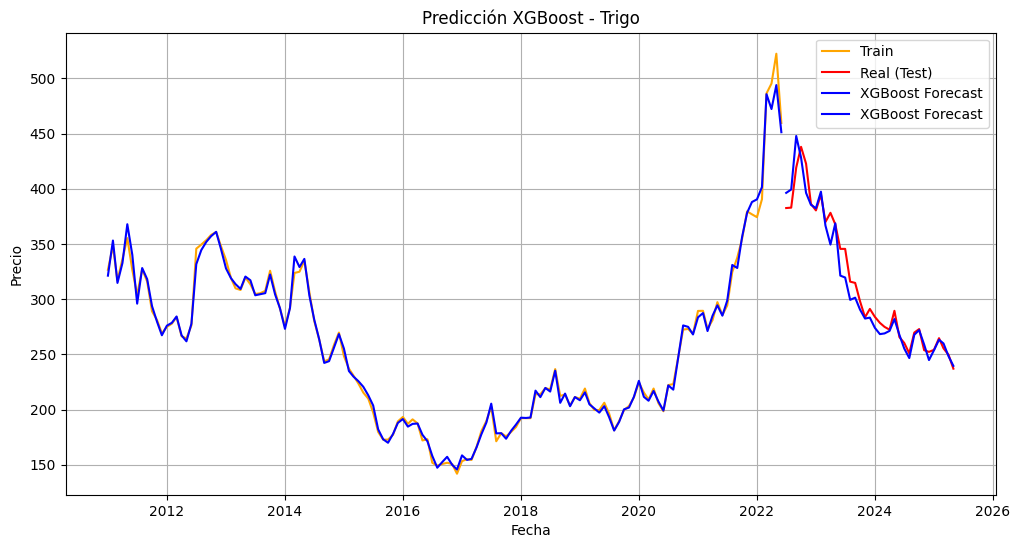

In [222]:
plt.figure(figsize=(12,6))
plt.plot(y_train.index, y_train, label='Train', color='orange')
plt.plot(y_test.index, y_test, label='Real (Test)', color='red')
plt.plot(y_test.index, y_pred, label='XGBoost Forecast', color='blue')
plt.plot(y_train.index, y_pred_train, label='XGBoost Forecast', color='blue')
plt.title("Predicción XGBoost - Trigo")
plt.xlabel("Fecha")
plt.ylabel("Precio")
plt.legend()
plt.grid(True)
plt.show()